# DESCRIZIONE DEL PROGETTO
Sei stato assunto dalla Pro National Bank come data scientist, il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia di un clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

A tal fine ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e ne pagano regolarmente le rate.

I dati sono in un file CSV presente a questo indirizzo: https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

Il file credit_scoring.csv contiene le informazioni dei correntisti che hanno richiesto l’apertura di una linea di credito.

ID: numero identificativo del cliente

CODE_GENDER: sesso del cleinte

FLAG_OWN_CAR: indicatore del possesso di un'automobile

FLAG_OWN_REALTY: indicatore del possesso di una casa

CNT_CHILDREN: numero di figli

AMT_INCOME_TOTAL: reddito annuale

NAME_INCOME_TYPE: tipo di reddito

NAME_EDUCATION_TYPE: livello di educazione

NAME_FAMILY_STATUS: Stato civile

NAME_HOUSING_TYPE:

DAYS_BIRTH: Numero di giorni trascorsi dalla nascita

DAYS_EMPLOYED: Numero di giorni trascorsi dalla data di assunzione, se positivo indica il numero di giorni da quando è disoccupato

FLAG_MOBIL: indicatore della presenza di un numero di cellulare

FLAG_WORK_PHONE: indicatore della presenza di un numero di telefono di lavoro

FLAG_PHONE: indicatore della presenza di un numero di telefono

FLAG_EMAIL: indicatore della presenza di un indirizzo email

OCCUPATION_TYPE: tipo di occupazione

CNT_FAM_MEMBERS: numero di familiari

TARGET: una variabile che vale 1 se il cliente ha una elevata affidabilità creditizia data dal pagamento costante delle rate e 0 altrimenti.

Devi realizzare un modello che preveda il target dato.

PUNTO BONUS

Se ad un cliente viene negata la carta di credito, il team deve essere in grado di fornirgli una motivazione, questo vuol dire che il tuo modello deve fornire delle indicazioni facilmente interpretabili.

# LIBRERIRE E FUNZIONI UTILI

In [ ]:
# importiamo classi e funzioni che possono esserci utili eventuali nuove classi o funzioni verranno aggiunte progressivamente
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import shuffle
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
def chi_square_analysis(df, variabili_indipendenti, variabili_risposta, ordinario=True):
    """
    Esegue il test del Chi-quadro e calcola i contributi delle classi per più variabili.

    Parametri:
    - df: DataFrame contenente i dati.
    - variabili_indipendenti: Lista dei nomi delle variabili indipendenti (variabili categoriali).
    - variabili_risposta: Lista dei nomi delle variabili di risposta (variabili categoriali).
    - ordinario: Booleano che indica se le variabili indipendenti sono ordinarie o meno.

    Restituisce:
    - risultati: Dizionario contenente i contributi per ciascuna variabile indipendente.
    """
    risultati = {}

    for var_indipendente in variabili_indipendenti:
        for var_risposta in variabili_risposta:
            print(f"Analisi per {var_indipendente} e {var_risposta}:\n")

            # Crea una tabella di contingenza
            contingency_table = pd.crosstab(df[var_indipendente], df[var_risposta])

            # Applica il test del Chi-quadro
            chi2, p, dof, expected = chi2_contingency(contingency_table)

            # Stampa i risultati generali
            print(f"Chi2 statistic: {chi2}")
            print(f"P-value: {p}")

            # Calcola i residui standardizzati
            residui_standardizzati = (contingency_table - expected) / np.sqrt(expected)
            print("Residui standardizzati:")
            print(residui_standardizzati)

            # Calcolo dei residui Pearson per valutare il contributo di ciascuna classe
            contributi_pearson = (residui_standardizzati ** 2)
            print("Contributi di Pearson (per classe):")
            print(contributi_pearson)

            # Inizializza il dizionario per i contributi
            contributi = {}

            if ordinario:
                # Calcola i contributi ponderati dall'ordine delle classi
                pesi = np.arange(len(contingency_table.index))
                contributi_ponderati = residui_standardizzati.multiply(pesi, axis=0)
                print("Contributi ponderati per ordinalità:")
                print(contributi_ponderati)

                # Riempie il dizionario con i contributi ponderati
                for i, classe in enumerate(contingency_table.index):
                    contributi[classe] = contributi_ponderati.iloc[i].sum()  # Somma dei contributi ponderati per ogni classe

            else:
                # Riempie il dizionario con i contributi di Pearson
                for i, classe in enumerate(contingency_table.index):
                    contributi[classe] = contributi_pearson.iloc[i].sum()  # Somma dei contributi di Pearson per ogni classe

            risultati[(var_indipendente, var_risposta)] = contributi
            print("\n---\n")

    return risultati

# IMPORTAZIONE DEL DATEST

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Progetto affidabilitá creditizia/Copia di credit_scoring.csv')
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


## CONTROLLO E PULIZIA DEL DATASET

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

Dalle info notiamo che:

* Sono presenti 19 features in totale, con un ammontare di 338427 osservazioni
* Vi é la presenza di dati nulli all'interno delle variabili andiamo ad approfondire, visualizzando quali features sono maggiormente interessate.
* Notiamo anche che stranamente manca un valore in diverse colonne e in una in particolare ne mancano molteplici; questo mi fa sospettare che ci sia una riga che ha diversi valori mancanti e una colonna con molti valori nulli.

In [ ]:
df.isna().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,1
NAME_HOUSING_TYPE,1


In [ ]:
df['OCCUPATION_TYPE'].value_counts()

,count
OCCUPATION_TYPE,
Laborers,60146
Core staff,33527
Sales staff,31652
Managers,27384
Drivers,20020
High skill tech staff,13399
Accountants,12281
Medicine staff,10438
Cooking staff,6248


Ci rendiamo conto che la variabile occupation Type presenta molteplici valori nulli che presumibilmente corrispondono ad altre tipologie di lavoro. Sostituiró la variabile con ALTRO vista la numerositá dei dati mancanti.

In [ ]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Altro')
df['OCCUPATION_TYPE'].value_counts()

,count
OCCUPATION_TYPE,
Altro,103342
Laborers,60146
Core staff,33527
Sales staff,31652
Managers,27384
Drivers,20020
High skill tech staff,13399
Accountants,12281
Medicine staff,10438


Troviamo la riga con la presenza in maggioranza di valori nulli e rimuoviamola dal dataset.

In [ ]:
# controllo della riga in questione
df_with_missing = df[df.drop(columns=['OCCUPATION_TYPE']).isna().any(axis=1)]
print(df_with_missing)
#rimozione della linea dal dataset
df = df.drop(index=338426, axis=1)
df.info()

             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426  6392180           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426           67500.0          Working      Secondary / se   

       NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338426                NaN               NaN         NaN            NaN   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
338426         NaN              NaN         NaN         NaN           Altro   

        CNT_FAM_MEMBERS  TARGET  
338426              NaN       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338426 entries, 0 to 338425
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338426 non-null  int64  
 1   CODE_GENDER          338426 non-null  object 
 2   FLAG_OWN_CAR         338

Controlliamo se c'é un disequilibrio della nsotra variabile Target.

In [ ]:
df['TARGET'].value_counts()

,count
TARGET,
0,308704
1,29722


Ora rimuovimao la colonna ID che non ha senso per il nostro modello.

In [ ]:
df= df.drop(columns=['ID'])
df.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Altro,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Altro,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


Controlliamo se ci sono righe ripetute all'interno del nostro dataset

In [ ]:
duplicates = df.duplicated().sum()
duplicates

263170

Notiamo la presenza di numerevoli duplicati nel dataset, le righe interessate presentano ripetutamente e in sequenza gli stessi identici valori per ogni variabile, per tanto rimuoveró i duplicati essendo questi con molta probabilitá un errore di raccolta del dato.

In [ ]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75256 entries, 0 to 338417
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          75256 non-null  object 
 1   FLAG_OWN_CAR         75256 non-null  object 
 2   FLAG_OWN_REALTY      75256 non-null  object 
 3   CNT_CHILDREN         75256 non-null  int64  
 4   AMT_INCOME_TOTAL     75256 non-null  float64
 5   NAME_INCOME_TYPE     75256 non-null  object 
 6   NAME_EDUCATION_TYPE  75256 non-null  object 
 7   NAME_FAMILY_STATUS   75256 non-null  object 
 8   NAME_HOUSING_TYPE    75256 non-null  object 
 9   DAYS_BIRTH           75256 non-null  float64
 10  DAYS_EMPLOYED        75256 non-null  float64
 11  FLAG_MOBIL           75256 non-null  float64
 12  FLAG_WORK_PHONE      75256 non-null  float64
 13  FLAG_PHONE           75256 non-null  float64
 14  FLAG_EMAIL           75256 non-null  float64
 15  OCCUPATION_TYPE      75256 non-null  obj

In [ ]:
df.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Altro,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
7,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464.0,365243.0,1.0,0.0,0.0,0.0,Altro,1.0,0
10,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872.0,-769.0,1.0,1.0,1.0,1.0,Accountants,2.0,0


# ANALISI DELLE VARIABILI E TEST DI CORRELAZIONE.
Prima di passare all'encoding analizziamo le variabili visivamente e con i diversi test.
Utilizzeremo la funzione scritta precedentemente per analizzare variabili categoriche ordinali e non ordinali.



## GRAFICI VARIABILI NUMERICHE CONTINUE E ANALISI

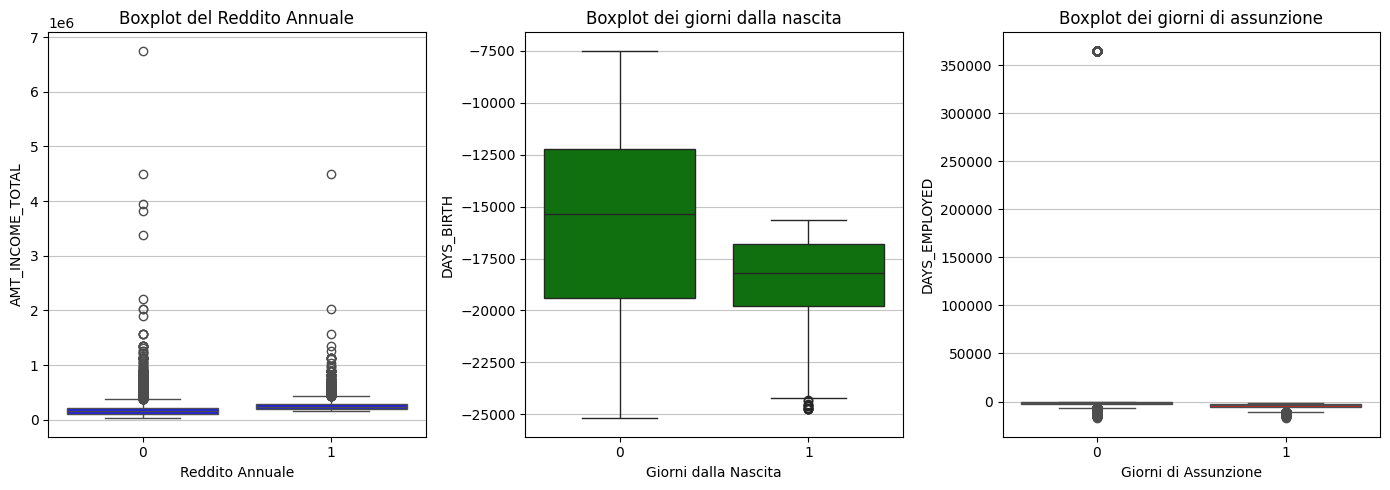

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=df, color='blue')
plt.title('Boxplot del Reddito Annuale')
plt.xlabel('Reddito Annuale')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 3, 2)
sns.boxplot(x='TARGET', y='DAYS_BIRTH', data=df, color='green')
plt.title('Boxplot dei giorni dalla nascita')
plt.xlabel('Giorni dalla Nascita')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 3, 3)
sns.boxplot(x='TARGET', y='DAYS_EMPLOYED', data=df, color='red')
plt.title('Boxplot dei giorni di assunzione')
plt.xlabel('Giorni di Assunzione')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

Da un primo plottaggio apparentemente in tutti e tre i casi abbiamo una differenza significativa in tutte e tre le variabili; notiamo in oltre la presenza di numerosi outlaiers. Prima di passare al test verifichiamo che tipo di distribuzione abbiamo davanti.

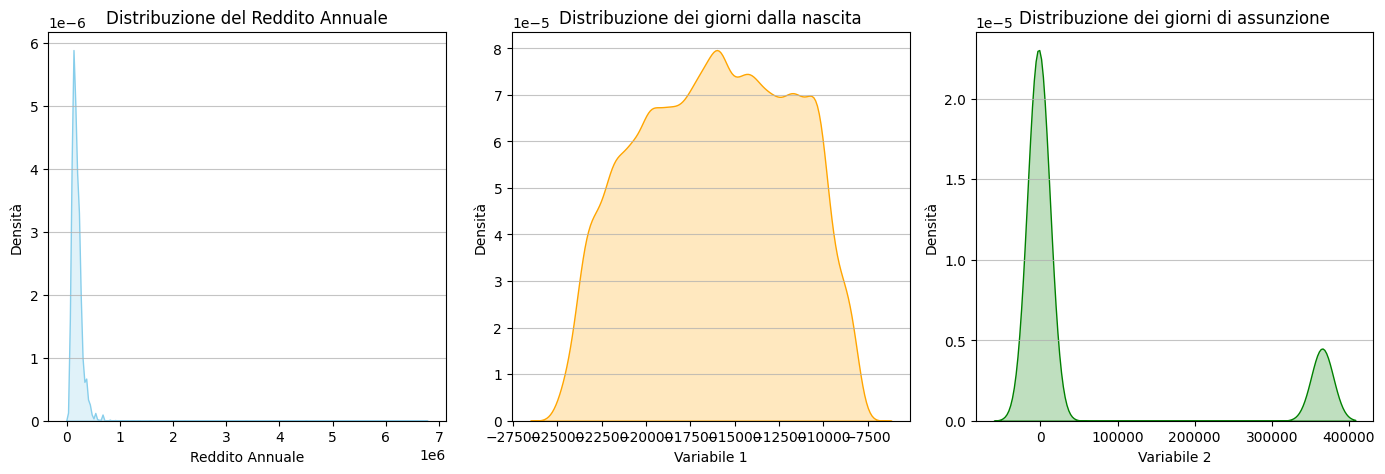

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(df['AMT_INCOME_TOTAL'], fill=True, color='skyblue')
plt.title('Distribuzione del Reddito Annuale')
plt.xlabel('Reddito Annuale')
plt.ylabel('Densità')
plt.grid(axis='y', alpha=0.75)


plt.subplot(1, 3, 2)
sns.kdeplot(df['DAYS_BIRTH'], fill=True, color='orange')
plt.title('Distribuzione dei giorni dalla nascita')
plt.xlabel('Variabile 1')
plt.ylabel('Densità')
plt.grid(axis='y', alpha=0.75)


plt.subplot(1, 3, 3)
sns.kdeplot(df['DAYS_EMPLOYED'], fill=True, color='green')
plt.title('Distribuzione dei giorni di assunzione')
plt.xlabel('Variabile 2')
plt.ylabel('Densità')
plt.grid(axis='y', alpha=0.75)


plt.tight_layout()
plt.show()

Vista la particolare forma delle mie distribuzioni applico il test di mann_whitney U per gruppi indipendenti per confermare matematicamente la significativitá della variabile.

In [ ]:
#AMT_INCOME_TOTAL
income_1 = df[df['TARGET'] == 0]['AMT_INCOME_TOTAL']
income_2= df[df['TARGET'] == 1]['AMT_INCOME_TOTAL']

stat, p_value = stats.mannwhitneyu(income_1, income_2)
print(f'TEST AMT_INCOME_TOTAL')
print(f'Statistica Mann-Whitney U: {stat}, P-value: {p_value}')

#DAYS_BIRTH
birth_1 = df[df['TARGET'] == 0]['DAYS_BIRTH']
birth_2 = df[df['TARGET'] == 1]['DAYS_BIRTH']

stat, p_value = stats.mannwhitneyu(birth_1, birth_2)
print(f'TEST DAYS_BIRTH')
print(f'Statistica Mann-Whitney U: {stat}, P-value: {p_value}')

#DAYS_EMPLOYED
group1 = df[df['TARGET'] == 0]['DAYS_EMPLOYED']
group2 = df[df['TARGET'] == 1]['DAYS_EMPLOYED']

stat, p_value = stats.mannwhitneyu(group1, group2)
print(f'TEST DAYS_EMPLOYED')
print(f'Statistica Mann-Whitney U: {stat}, P-value: {p_value}')

TEST AMT_INCOME_TOTAL
Statistica Mann-Whitney U: 103559746.0, P-value: 0.0
TEST DAYS_BIRTH
Statistica Mann-Whitney U: 347423919.5, P-value: 0.0
TEST DAYS_EMPLOYED
Statistica Mann-Whitney U: 407339465.0, P-value: 0.0


Possiamo notare come un P-value di 0 confermi quello che giá avevamo visto dagli scatterplot.

In [ ]:
def chi_square_test(df, categorical_var, target):
    contingency_table = pd.crosstab(df[categorical_var], df[target])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2_stat, p_value

In [ ]:
categorical_vars=['FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE']

for var in categorical_vars:
    chi2_stat, p_value = chi_square_test(df, var, 'TARGET')
    print(f"Test del Chi-Quadro per {var}:\nChi-square statistic: {chi2_stat:.3f}, P-value: {p_value:.3f}\n")

Test del Chi-Quadro per FLAG_OWN_CAR:
Chi-square statistic: 172.916, P-value: 0.000

Test del Chi-Quadro per NAME_EDUCATION_TYPE:
Chi-square statistic: 163.547, P-value: 0.000



Il P_value inferiore di 0 mi porta a concludere che entrambe le variabili siano importanti per il mio modello

# ANALISI DELLE VARIABILI CATEGORICHE NON ORDINARIE

In [ ]:
chi_square_analysis(df, ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE'], ['TARGET'], ordinario=False)

Analisi per CODE_GENDER e TARGET:

Chi2 statistic: 45.69123598969293
P-value: 1.3844078830694745e-11
Residui standardizzati:
TARGET              0         1
CODE_GENDER                    
F            1.251722 -3.798956
M           -1.710232  5.190528
Contributi di Pearson (per classe):
TARGET              0          1
CODE_GENDER                     
F            1.566808  14.432065
M            2.924895  26.941578

---

Analisi per FLAG_OWN_CAR e TARGET:

Chi2 statistic: 172.9159452737578
P-value: 1.7073628645261294e-39
Residui standardizzati:
TARGET               0         1
FLAG_OWN_CAR                    
N             2.493558 -7.567909
Y            -3.278572  9.950412
Contributi di Pearson (per classe):
TARGET                0          1
FLAG_OWN_CAR                      
N              6.217833  57.273240
Y             10.749034  99.010706

---

Analisi per FLAG_OWN_REALTY e TARGET:

Chi2 statistic: 78.91585394660954
P-value: 6.481254073059015e-19
Residui standardizzati:
TARGE

{('CODE_GENDER', 'TARGET'): {'F': 15.99887323073002, 'M': 29.86647299805425},
 ('FLAG_OWN_CAR', 'TARGET'): {'N': 63.49107232702851, 'Y': 109.75973948786188},
 ('FLAG_OWN_REALTY', 'TARGET'): {'N': 54.0344445119606,
  'Y': 25.115667528527318},
 ('NAME_INCOME_TYPE', 'TARGET'): {'Commercial associate': 296.271820753768,
  'Pensioner': 1315.257195887223,
  'State servant': 168.72770029731524,
  'Student': 0.15992043877625542,
  'Working': 11.813407622705064},
 ('NAME_EDUCATION_TYPE', 'TARGET'): {'Academic degree': 1.3840033150132012,
  'Higher education': 93.43956497703068,
  'Incomplete higher': 30.409932901207906,
  'Lower secondary': 21.548780851228084,
  'Secondary / secondary special': 16.764337759152195},
 ('NAME_FAMILY_STATUS', 'TARGET'): {'Civil marriage': 11.22895115622481,
  'Married': 5.694415581955628,
  'Separated': 44.14186045617452,
  'Single / not married': 57.24883364139605,
  'Widow': 0.702980742960943},
 ('NAME_HOUSING_TYPE', 'TARGET'): {'Co-op apartment': 1.3840865630716

# ANALISI DELLE VARIABILI CATEGORICHE ORDINALI

In [ ]:
chi_square_analysis(df, ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], ['TARGET'], ordinario=True)

Analisi per CNT_CHILDREN e TARGET:

Chi2 statistic: 618.4062875386815
P-value: 1.6157260119378241e-125
Residui standardizzati:
TARGET               0          1
CNT_CHILDREN                     
0            -3.994038  12.121840
1             3.653257 -11.087574
2             5.271887 -16.000091
3             1.646838  -4.998125
4             0.502075  -1.523788
5             0.290222  -0.880818
6             0.145822  -0.442566
7             0.103111  -0.312942
9             0.103111  -0.312942
12            0.103111  -0.312942
14           -0.598680   1.816983
19            0.103111  -0.312942
Contributi di Pearson (per classe):
TARGET                0           1
CNT_CHILDREN                       
0             15.952340  146.939015
1             13.346284  122.934303
2             27.792792  256.002915
3              2.712074   24.981255
4              0.252079    2.321930
5              0.084229    0.775841
6              0.021264    0.195865
7              0.010632    0.097932
9

{('CNT_CHILDREN', 'TARGET'): {0: 0.0,
  1: -7.434317666727003,
  2: -21.456408286493108,
  3: -10.053862890610187,
  4: -4.086854040494963,
  5: -2.9529829033923987,
  6: -1.7804672928088634,
  7: -1.4688105791636685,
  9: -1.6786406619013352,
  12: -1.8884707446390019,
  14: 12.183034677930939,
  19: -2.308130910114336},
 ('CNT_FAM_MEMBERS', 'TARGET'): {1.0: 0.0,
  2.0: 8.232955948711911,
  3.0: -14.401107710853164,
  4.0: -30.80806986210824,
  5.0: -13.38465177571279,
  6.0: -4.854593900238487,
  7.0: -3.35727863317211,
  8.0: -2.0772118416103407,
  9.0: -1.6786406619013352,
  11.0: -1.8884707446390019,
  14.0: -2.0983008273766686,
  15.0: 13.40133814572403,
  20.0: -2.517960992852003}}

In conclusione dai risultati ottenuti manterró le variabili con i contributi piú alti e con i valori di p-value uguali o inferiori di 0; procederó con le seguenti modifiche:

CNT_CHILDREN : Tutte da eliminare al di fuori di 0,1,2,3

CNT_FAM_MEMBERS : Tutte da eliminare al di fuori di 1,2,3,4,5

CODE_GENDER : da mantenere

FLAG_OWN_CAR: da mantenere

FLAG_OWN_REALTY : da mantenere

AMT_INCOME_TOTAL : da mantenere

NAME_INCOME_TYPE: da eliminare la classe students

NAME_EDUCATION_TYPE: da eliminare la classe accademic degree

NAME_FAMILY_STATUS: da eliminare la classe Merried

NAME_HOUSING_TYPE: da eliminare Office apartament

DAYS_BIRTH da mantenere

DAYS_EMPLOYED da mantenere

FLAG_MOBIL da rimuovere interamente

FLAG_WORK_PHONE da mantenere

FLAG_PHONE da mantenere

FLAG_EMAIL da mantenere

OCCUPATION_TYPE : da eliminare le classi: cleaning staff, secretaries, security staff, IT staff

# PULIZIA ED ENCODING DELLE VARIABILI

In [ ]:
categorical_cols = ['CNT_CHILDREN',
                   'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                   'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                   'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Applica get_dummies
df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na= False)
df_encoded.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,CNT_FAM_MEMBERS_4.0,CNT_FAM_MEMBERS_5.0,CNT_FAM_MEMBERS_6.0,CNT_FAM_MEMBERS_7.0,CNT_FAM_MEMBERS_8.0,CNT_FAM_MEMBERS_9.0,CNT_FAM_MEMBERS_11.0,CNT_FAM_MEMBERS_14.0,CNT_FAM_MEMBERS_15.0,CNT_FAM_MEMBERS_20.0
0,M,Y,Y,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,M,Y,Y,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,F,N,Y,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
7,F,N,Y,283500.0,-22464.0,365243.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
10,M,Y,Y,270000.0,-16872.0,-769.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# rimuoviamo le features non essenziali
df_pulito = df_encoded.drop(columns=['CNT_CHILDREN_4',
       'CNT_CHILDREN_5', 'CNT_CHILDREN_6', 'CNT_CHILDREN_7', 'CNT_CHILDREN_9',
       'CNT_CHILDREN_12', 'CNT_CHILDREN_14', 'CNT_CHILDREN_19', 'CNT_FAM_MEMBERS_6.0', 'CNT_FAM_MEMBERS_7.0',
       'CNT_FAM_MEMBERS_8.0', 'CNT_FAM_MEMBERS_9.0', 'CNT_FAM_MEMBERS_11.0',
       'CNT_FAM_MEMBERS_14.0', 'CNT_FAM_MEMBERS_15.0', 'CNT_FAM_MEMBERS_20.0', 'NAME_INCOME_TYPE_Student', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_FAMILY_STATUS_Married', 'NAME_HOUSING_TYPE_Office apartment','OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_IT staff'], axis=1)

In [ ]:
df_pulito.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'TARGET', 'CNT_CHILDREN_0',
       'CNT_CHILDREN_1', 'CNT_CHILDREN_2', 'CNT_CHILDREN_3',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'O

In [ ]:
gender_map = {'M': 1, 'F': 0}
car_map = {'Y': 1, 'N': 0}
flag_map = {'Y': 1, 'N': 0}

df_pulito['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: gender_map[x])
df_pulito['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].apply(lambda x: car_map[x])
df_pulito['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].apply(lambda x: flag_map[x])

df_pulito.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Waiters/barmen staff,CNT_FAM_MEMBERS_1.0,CNT_FAM_MEMBERS_2.0,CNT_FAM_MEMBERS_3.0,CNT_FAM_MEMBERS_4.0,CNT_FAM_MEMBERS_5.0
0,1,1,1,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
2,1,1,1,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
3,0,0,1,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,...,False,False,False,True,False,True,False,False,False,False
7,0,0,1,283500.0,-22464.0,365243.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
10,1,1,1,270000.0,-16872.0,-769.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
exclude_cols = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Applica la conversione solo alle colonne che non sono nella lista exclude_cols
df_pulito = df_pulito.apply(lambda col: col.astype(int) if col.name not in exclude_cols else col)
df_pulito.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Waiters/barmen staff,CNT_FAM_MEMBERS_1.0,CNT_FAM_MEMBERS_2.0,CNT_FAM_MEMBERS_3.0,CNT_FAM_MEMBERS_4.0,CNT_FAM_MEMBERS_5.0
0,1,1,1,427500.0,-12005.0,-4542.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,112500.0,-21474.0,-1134.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,270000.0,-19110.0,-3051.0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,0
7,0,0,1,283500.0,-22464.0,365243.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,1,1,270000.0,-16872.0,-769.0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_pulito.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75256 entries, 0 to 338417
Data columns (total 52 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   CODE_GENDER                                        75256 non-null  int64  
 1   FLAG_OWN_CAR                                       75256 non-null  int64  
 2   FLAG_OWN_REALTY                                    75256 non-null  int64  
 3   AMT_INCOME_TOTAL                                   75256 non-null  float64
 4   DAYS_BIRTH                                         75256 non-null  float64
 5   DAYS_EMPLOYED                                      75256 non-null  float64
 6   FLAG_MOBIL                                         75256 non-null  int64  
 7   FLAG_WORK_PHONE                                    75256 non-null  int64  
 8   FLAG_PHONE                                         75256 non-null  int64  
 9   FLAG_EMAIL

# SCATTER MATRIX
Di seguito é rappresentata la scatter matrix del df senza modifiche.



Scatterplot dati non modificati

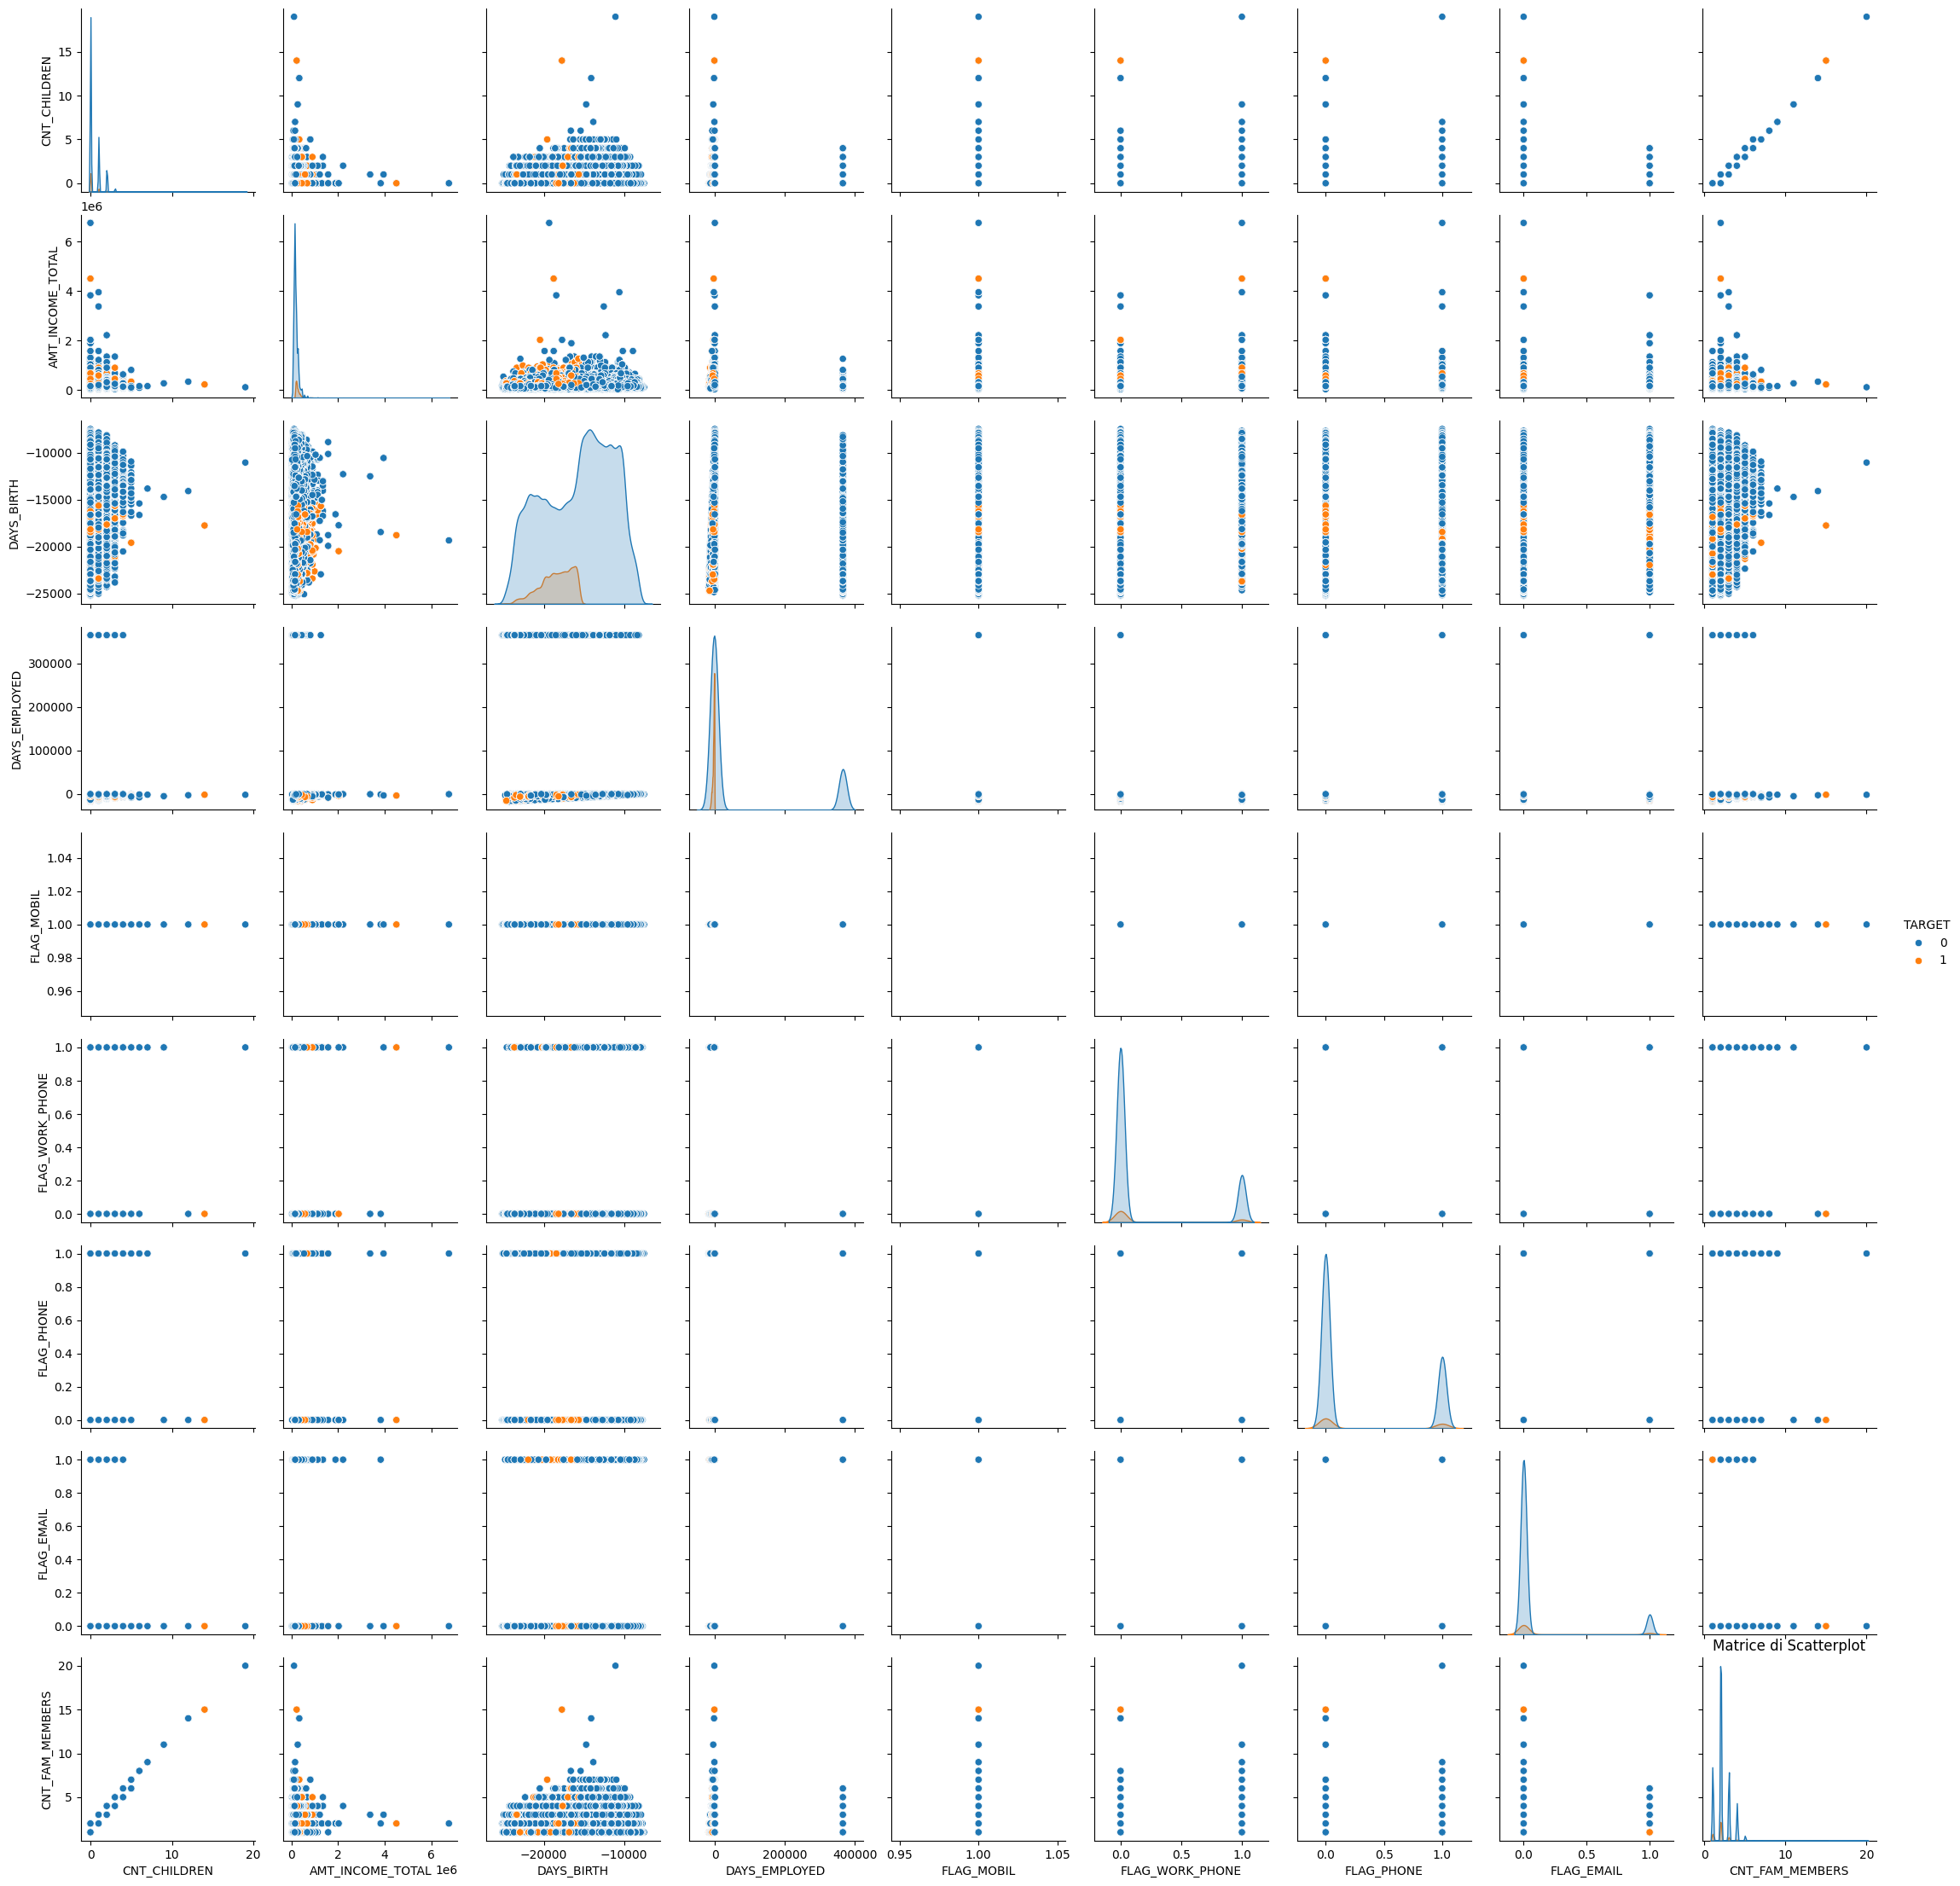

Dallo scatter plot notiamo che non sembra ci siano relazioni rappresentabili con un modello di tipo lineare possiamo andare a verificare la cosa testando diversi modelli e andando a confrontare i diversi risultati.

# MODELLAZIONE

## SVM lineare e RFB


1.   Partiremo con il testare un SVM Lineare e un RFB per confermare la teoria riguardante la non linearitá delle relazioni, e successivamente utilizzeremo un random forest poiché l'implementazione dell'svm rfb e polinomiale richiede troppo tempo per essere addestrato.



In [ ]:
X = df_pulito.drop('TARGET', axis=1)
y = df_pulito['TARGET']

# divisione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# estraggo le variabili per poi standardizzare le numeriche e passare oltre le categoriche
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# preporcessor con standard scaler sulle variabili numeriche continue
preprocessor = ColumnTransformer(
    transformers=[
        ('num', ImbPipeline(steps=[('scaler', StandardScaler())]), numerical_features),
                                   ('cat', 'passthrough', categorical_features)
    ])

# parametri da testare
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

results = {}

#cicli sui diversi paramentri
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            print(f"Testing: C={C}, kernel={kernel}, gamma={gamma}")

            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),
                ('classifier', SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            test_score = accuracy_score(y_test, y_pred)
            results[(C, kernel, gamma)] = test_score

            print(f"Final test accuracy: {test_score:.4f} for C={C}, kernel={kernel}, gamma={gamma}")
            print("Classification report:\n", classification_report(y_test, y_pred))

# valutazioni
print("\nResults summary:")
for params, score in results.items():
    C, kernel, gamma = params
    print(f"C {C}, Kernel {kernel}, Gamma {gamma}: Test Accuracy = {score:.4f}")


scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)

print("\nCross-validation results:")
for metric in scoring:
    print(f"Mean {metric}: {cv_results['test_' + metric].mean():.4f} ± {cv_results['test_' + metric].std():.4f}")

Da un primo test abbiamo appurato che i modelli di tipo lineare performano peggio quindi sono da escludere, come avevamo visto dalla scattar matrix, il nostro modello necessita di un modello di tipo non lineare per performare al meglio. Tuttavia abbiamo oltresi notato che benché abbiamo usato la tecnica di oversimpling per compensare il disequilibrio della variabile di risposta la precision relativa alla variabile di risposta risulta molto squilibrata. Proveremo prima di procedere con il random forest proveremo un altro svm con kernel polinomiale e rfb impostando anche diversi livelli di soglia per cercare di equilibrare anche la classe 1 mantenendo accuracy e recall a livelli accettabili.

## RANDOM FOREST

Iniziamo con il testare un random forest con diversi parametri ed effettuando la corss validiation per verificare che non overfitti; cosi facendo andremo a selezionare il modello migliore per i successivi step.

In [ ]:
X = df_pulito.drop('TARGET', axis=1)
y = df_pulito['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Parametri da testare
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True]
}

# Pipeline Random Forest con SMOTE e class_weight bilanciata (lo shuffle viene gestito in automatico quando usato in pipeline)
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# GridSearchCV con cross-validation per verificare con l'accuracy se cé o non cé overfitting (shuffle: stessa cosa in cv all'interno della Gridserch)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Esegui il fit della GridSearchCV
grid_search.fit(X_train, y_train)

# mettiamo i risultati della cross validation in un dataframe per essere facilmente consultabili
results = pd.DataFrame(grid_search.cv_results_)

# Ordiniamo i risultati
results_sorted = results.sort_values(by='rank_test_score', ascending=True)

# Fit di tutti i modelli sui dati di addestramento e predizioni sui dati di test
for i in range(len(results_sorted)):
    params = results_sorted.iloc[i]['params']
    print(f"Model {i} (params: {params}):")

    # Estrai i parametri del modello
    classifier_params = {key.replace('classifier__', ''): value for key, value in params.items()}

    # imposto la pipeline per allenare il modello
    model = ImbPipeline(steps=[
        ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),  # SMOTE con random_state
        ('classifier', RandomForestClassifier(**classifier_params, class_weight='balanced', random_state=42)),  # RF con random_state
    ])

    # Alleno il modello
    model.fit(X_train, y_train)

    # faccio le predizioni
    y_pred = model.predict(X_test)

    # genero il classification report per tutti i modelli allenati con l'accuracy in CV.
    class_report = classification_report(y_test, y_pred)
    print(f"Classification Report for model {i}:")
    print(class_report)
    print(f"CV Accuracy: {results_sorted.iloc[i]['mean_test_score']}")
    print("-" * 60)

Model 0 (params: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}):
Classification Report for model 0:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20333
           1       0.56      0.98      0.71      2244

    accuracy                           0.92     22577
   macro avg       0.78      0.95      0.83     22577
weighted avg       0.95      0.92      0.93     22577

CV Accuracy: 0.9223978887882627
------------------------------------------------------------
Model 1 (params: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}):
Classification Report for model 1:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20333
           1       0.56      0.9

il modello migliore é il 19 proviamo a sistemarlo cambiando il valore di soglia per vedere se riusciamo ad equilibrare le due classi

Parameters of model 18: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


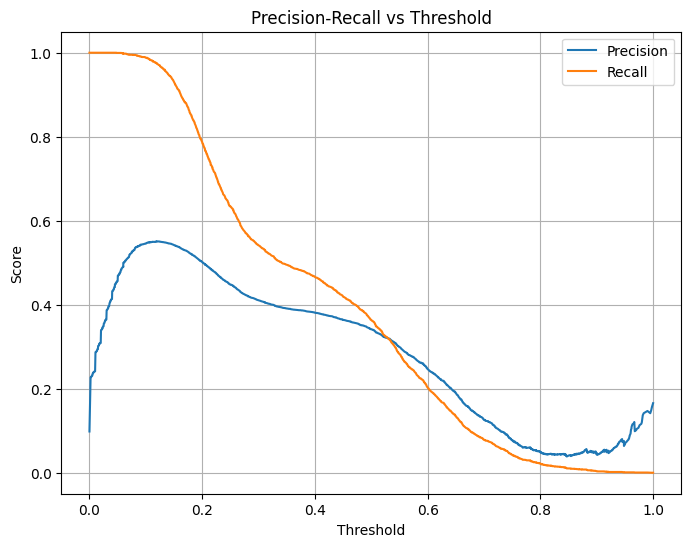

Classification Report for threshold 0.11:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20333
           1       0.55      0.98      0.70      2244

    accuracy                           0.92     22577
   macro avg       0.77      0.95      0.83     22577
weighted avg       0.95      0.92      0.93     22577

Classification Report for threshold 0.12:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20333
           1       0.55      0.97      0.70      2244

    accuracy                           0.92     22577
   macro avg       0.77      0.94      0.83     22577
weighted avg       0.95      0.92      0.93     22577

Classification Report for threshold 0.13:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20333
           1       0.55      0.96      0.70      2244

    accuracy                           0.92     22577
  

In [ ]:
model_index = 18
params = results.iloc[model_index]['params']
classifier_params = {key.replace('classifier__', ''): value for key, value in params.items()}

print(f"Parameters of model {model_index}: {classifier_params}")

# Pipeline
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit del modello sui dati di train
modello_selezionato = pipeline.fit(X_train, y_train)

# Estrai le probabilità di predizione con il modello fittato sul set di test (classe 1)
y_proba = modello_selezionato.predict_proba(X_test)[:, 1]

# Plottiamo l'andamento di precision e recall per le soglie decisionali
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Traccia la curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Funzione per previsioni data una determinata soglia e classification report per la soglia di riferimento
def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    print(f"Classification Report for threshold {threshold}:")
    print(classification_report(y_true, y_pred))

# Soglie da testare in base al grafico della curva precision recall
thresholds = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
for threshold in thresholds:
    evaluate_threshold(y_test, y_proba, threshold)



Come possiamo notare dal grafico i valori di soglia che massimizzano recal e precision sono compresi tra 0 e 0.2. Siamo principlamente interessati a riuscire a classificare correttamente le persone che sicuramente non hanno l'affidabilitá creditizia per avere la carta di credito, per questo motivo ho scelto di testare i valori di soglia entro questo range per massimizzare precision e recall di quella determinate classe.

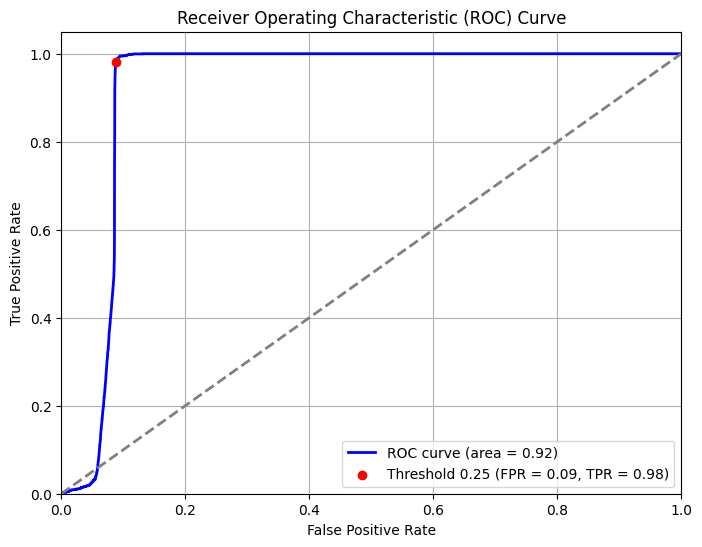

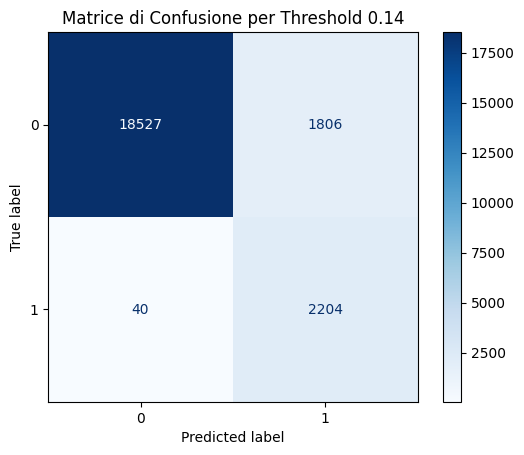

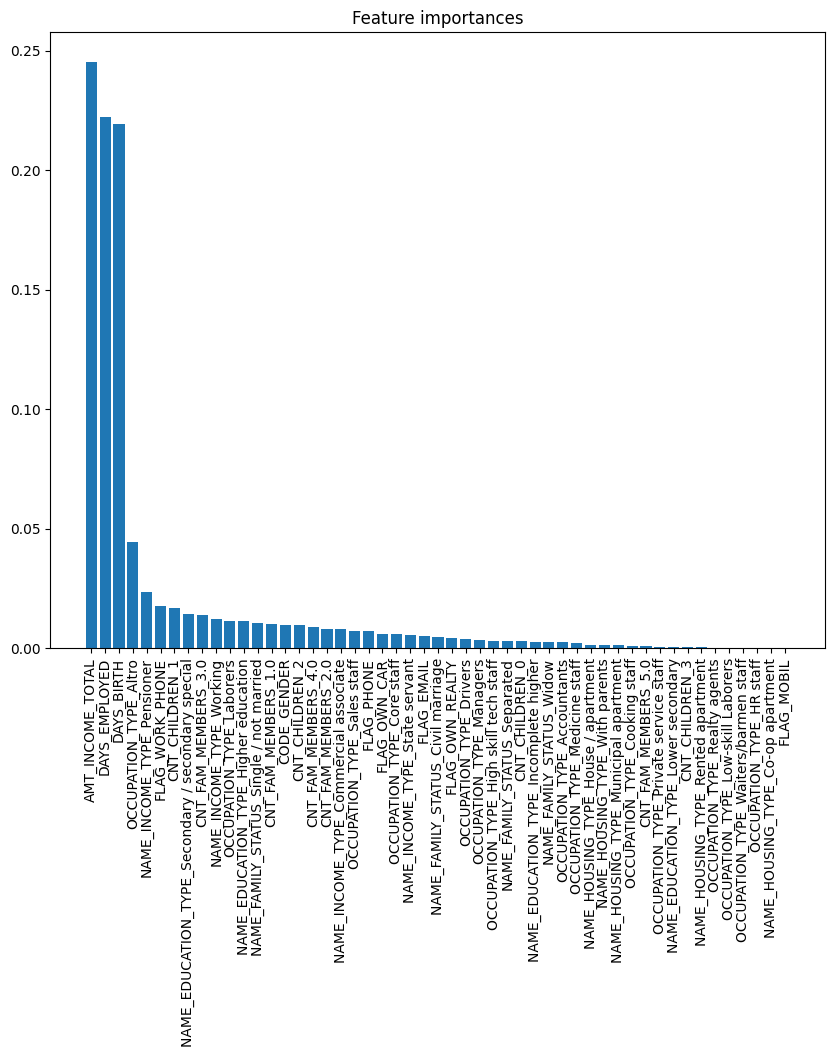

In [ ]:
# Calcola i valori della curva ROC usando le probabilità originali
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Applica il threshold di 0.11 per ottenere le nuove previsioni binarie
threshold = 0.11
y_pred = (y_proba >= threshold).astype(int)

# Calcola il TPR e FPR per il threshold specifico
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_new = fp / (fp + tn)
tpr_new = tp / (tp + fn)

# Traccia la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.scatter(fpr_new, tpr_new, color='red', zorder=5, label=f'Threshold 0.25 (FPR = {fpr_new:0.2f}, TPR = {tpr_new:0.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

cm = np.array([[tn, fp], [fn, tp]])

# Visualizzazione della matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matrice di Confusione per Threshold 0.14')
plt.show()

# estraggo le variabili piú importanti in fase di classificazione
feature_importances = modello_selezionato.steps[-1][1].feature_importances_

# Controlliamo l'importanza delle nostre features
indices = np.argsort(feature_importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.show()



Ora proviamo a fornire qualche informazioni in piú in merito alle variabili maggiormente importanti.

Per la feature 'AMT_INCOME_TOTAL', i cambiamenti significativi avvengono nel range: [81000.0, 1350000.0]


<Figure size 1000x600 with 0 Axes>

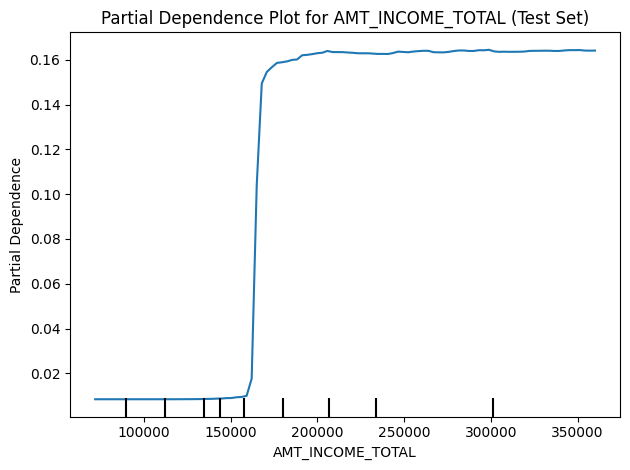

Per la feature 'DAYS_BIRTH', i cambiamenti significativi avvengono nel range: [-24770.0, -12887.0]


<Figure size 1000x600 with 0 Axes>

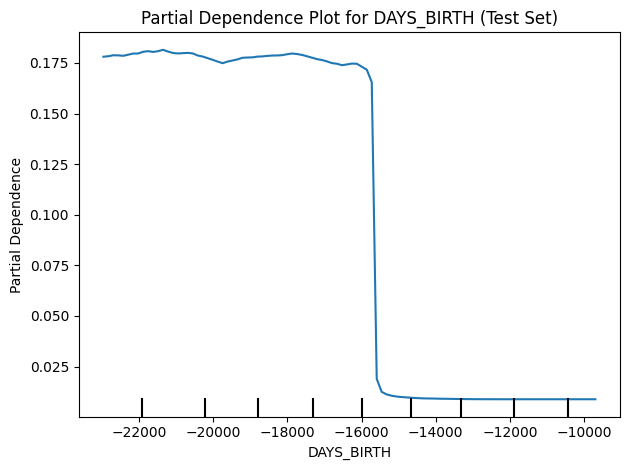

Per la feature 'DAYS_EMPLOYED', i cambiamenti significativi avvengono nel range: [-16767.0, -221.0]


<Figure size 1000x600 with 0 Axes>

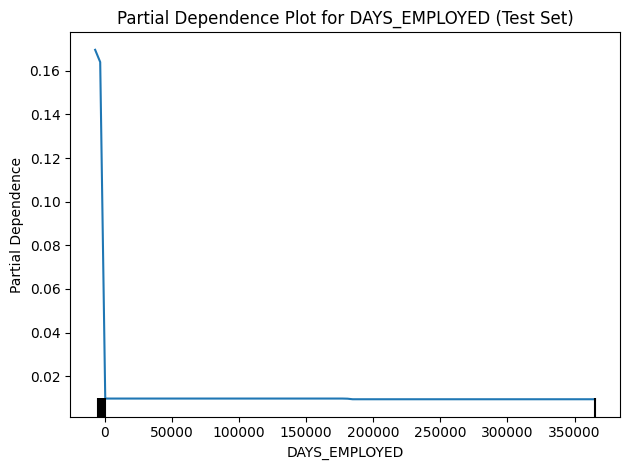

In [ ]:
for feature in features:
    # Creazione di un nuovo grafico per ogni feature
    plt.figure(figsize=(10, 6))

    # Utilizza il modello allenato e il set di test per calcolare il PDP
    PartialDependenceDisplay.from_estimator(modello_selezionato, X_test, features=[feature], ax=None)

    # Identifica i valori della feature nel set di test che superano la soglia
    values_above_threshold = X_test[feature][y_proba >= threshold]

    # Se esistono valori significativi sopra la soglia, stampare il range
    if len(values_above_threshold) > 0:
        range_min = values_above_threshold.min()
        range_max = values_above_threshold.max()
        print(f"Per la feature '{feature}', i cambiamenti significativi avvengono nel range: [{range_min}, {range_max}]")

    # Aggiungi titolo e etichette agli assi
    plt.title(f'Partial Dependence Plot for {feature} (Test Set)')
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence')
    plt.tight_layout()
    plt.show()

# CONCLUSIONI


Il modello con la soglia corretta classifica molto bene le osservazioni negative quando il cliente non ha l'affidabilitá creditiza necessaria per ottenere la carta di credito; con una recall di 0.91 indica che che cé ancora un 9% di clienti non affidabili che vengono classificati erronamente come affidabile. (Confusion Matrix).

Per la classe 1 infatti benché abbiamo una recall di 0.98 e una precision di 0.55, questo significa che il modello tende a classificare come affidabili alcuni clienti che in realtá non lo sono; Tuttavia, poiché la recall per i clienti affidabili é molto alta questo comporta che la maggior parte degli affidabili é correttamente identificata.

Il modello in conclusione sebbene faccia qualche errore nel predire chi é affidabile é molto sicuro nel proteggere contro eventuali clienti non affidabili riducendo il rischio nel complesso.

PDP
Gli ultimi tre grafici, possono aiutare i responsabili del rilascio delle carte di credito fornendo delle soglie relative alle variabili maggiormente decisive in termini di classificazione. Le curve rappresentano i momenti in cui al variare delle variabile registriamo  un forte cambiamento del modello in termini decisionali, in sostanza si possono identificare dei range di valore entro cui l'indecisione del modello aumenta, sapendo che il mdoello identifica molto precisamente i clienti che non hanno i requisiti minimi per una carta di credito prima o dopo questo step (a seconda dell'andamento del grafico) possiamo essere certi che il nostro clinete non meriti la corta di credito.

Le soglie identificative aiutano a capire dove il modello potrebbe fare piú fatica a prendere una decisione sicura, fuori da questi intervalli la predizione del modello é molto piú affidabile. Utilizzando queste soglie in combinata é possibile fare una valutazione piú dettagliata e fornire delle motivazioni valide se dovessimo rifiutare il rilascio della carta.

AMT_INCOME_TOTAL: [min:81000.0, max:1350000.0] Se il reddito di un cliente é inferiore a 81000 il modello li classifica come non affidabili con alta certezza. Il massimo di sicurezza per l'affidabilitá la otteniamo dopo il massimo tuttavia possiamo notare come la curva si stabilizzi superando i 200000.

DAYS_BIRTH: [min:-24770.0, max:-12887.0] Possiamo dire che per clienti piú giovani fino ai 35 anni (considerati i piú affidabili) e piú vecchi di 68 (considerati meno affidabili) l'incertezza sulla classifcazione é molto bassa, la massima incertezza l'abbiamo fra i 35 e i 68.

DAYS_EMPLOYED: [min:-16767.0, max:-221.0] il discorso é simile alla variabile precedente i range in anni vanno da meno di un anno a 45 anni, il modello é piú incerto a classificare in questo range ed é piú sicuro prima e dopo.

Considerando queste variabili e potendo andare a confrontare i valori delle variabili su dove si posizionano all'interno della curva possiamo capire quanto quel valore in termini di probabilitá predetta tenda ad essere classificato come appartenente alla classe 1, fornendo un valido aiuto per fornire motivazioni ai clienti ed aiutare il personale a prendere decisioni piú accurate.